In [1]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from natsort import natsorted

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

/mnt/C45ADD865ADD7620/i3d-rrc/ic-topo-nav/mickst3r


In [2]:
from mast3r_src.model import AsymmetricMASt3R

from dust3r_src.dust3r.inference import inference
from dust3r_src.dust3r.utils.image import load_images

from src.datasets.utils import read_intrinsics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model_name = "./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth"
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

Using device: cuda
... loading model from ./checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


In [3]:
dataset_root = Path("./data/mapfree/val")

VAL_SCENES = ["s00460", "s00474", "s00482", "s00489", "s00495"]
scene_paths = [dataset_root / scene for scene in VAL_SCENES]

print(f"Found {len(scene_paths)} scenes")

scene_path = scene_paths[0]
print(f"Selected scene: {scene_path}")

intrinsics_path = scene_path / "intrinsics.txt"
K = read_intrinsics(intrinsics_path, resize=(384, 512)) # resize to model input size

reference_image_folder = scene_path / "seq0"
image_r_path = reference_image_folder / "frame_00000.jpg"

query_image_folder = scene_path / "seq1"
query_image_paths = natsorted(list(query_image_folder.glob("*.jpg")))

QUERY_NAT_IDX = 0
image_q_path = query_image_paths[QUERY_NAT_IDX]

Found 5 scenes
Selected scene: data/mapfree/val/s00460


In [4]:
images = load_images([str(image_r_path), str(image_q_path)], size=512)
output_1 = inference([tuple(images)], model, device, batch_size=1, verbose=False)
output_2 = inference([tuple(images[::-1])], model, device, batch_size=1, verbose=False)

# double mast3r predictions - 🔷 schema below
# view1, view2 -> dicts with keys 'img', 'true_shape', 'idx', 'instance'
# view["img"] -> torch.Tensor of shape (1, 3, H_resize, W_resize) standardized RGB image
# view["true_shape"] -> torch.Tensor of shape (1, 2) H_resize, W_resize information
# view["idx"] / view["instance"] -> list of length 1 with the int/str index of the image resp.

# pred1, pred2 -> dict with keys 'pts3d', 'conf', 'desc', 'desc_conf'
# pred["pts3d"] -> torch.Tensor of shape (1, H_resize, W_resize, 3) pointmaps
# pred["conf"] / pred["desc_conf"]  -> torch.Tensor of shape (1, H_resize, W_resize) confidence map for pts3d and desc resp.
# pred["desc"] -> torch.Tensor of shape (1, H_resize, W_resize, 24) descriptor map
view1, pred1 = output_1['view1'], output_1['pred1']
view2, pred2 = output_2['view1'], output_2['pred1']

>> Loading a list of 2 images
 - adding data/mapfree/val/s00460/seq0/frame_00000.jpg with resolution 540x720 --> 384x512
 - adding data/mapfree/val/s00460/seq1/frame_00000.jpg with resolution 540x720 --> 384x512
 (Found 2 images)


Confidence shape: torch.Size([1, 512, 384]), torch.Size([1, 512, 384])
Depths shape: torch.Size([1, 512, 384]), torch.Size([1, 512, 384])
Descriptors shape: torch.Size([1, 512, 384, 24]), torch.Size([1, 512, 384, 24])


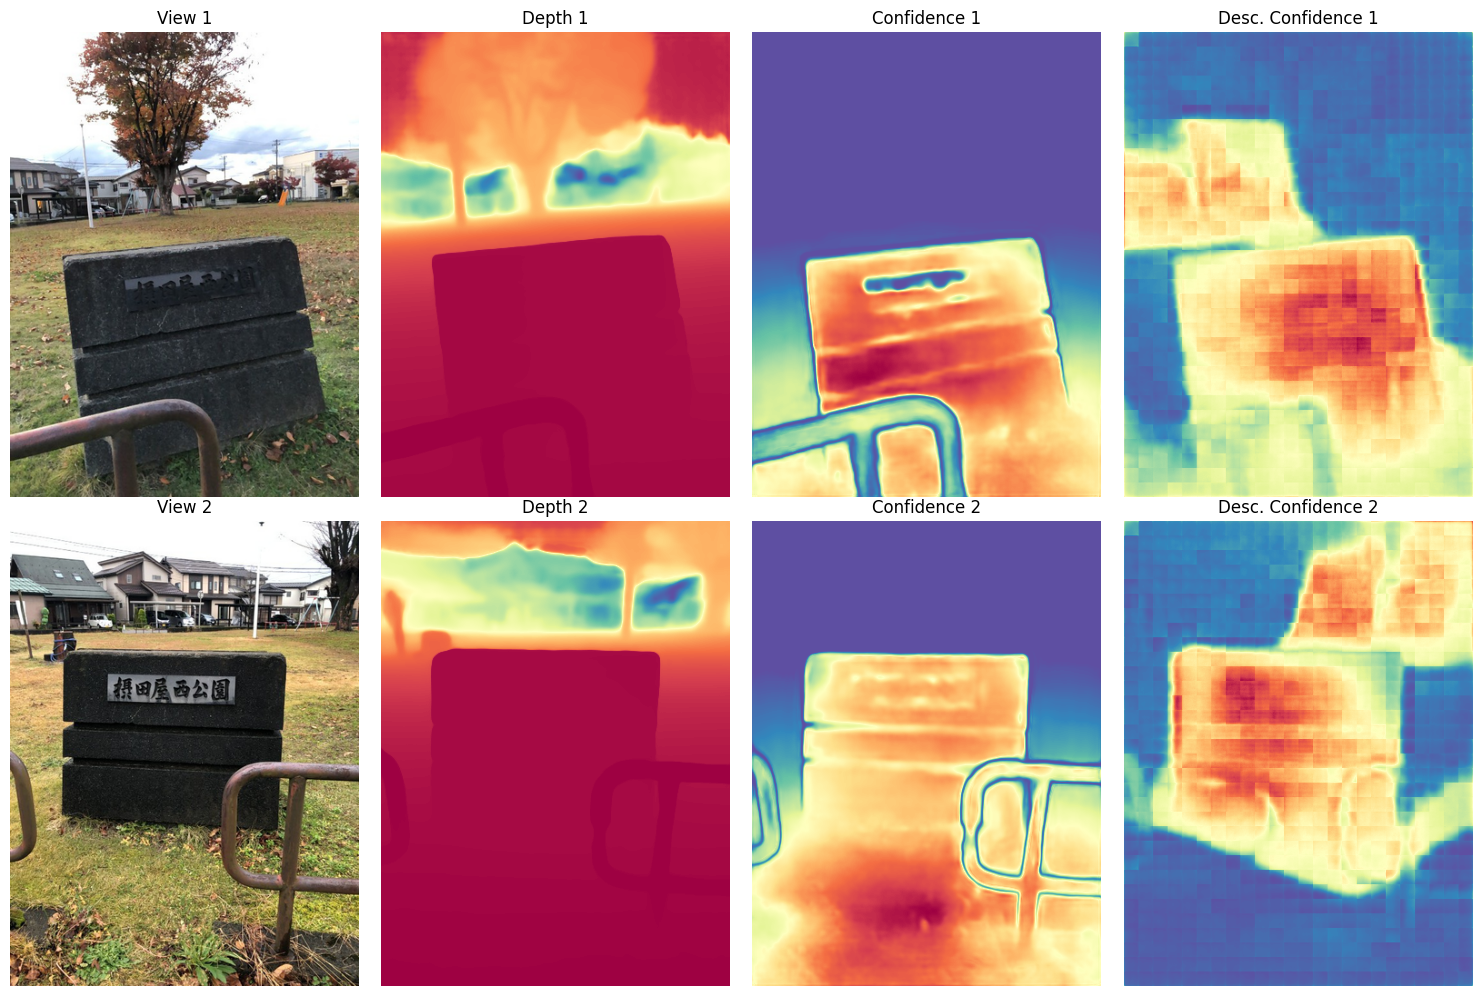

In [5]:
image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

viz_imgs = []
for i, view in enumerate([view1, view2]):
    rgb_tensor = view['img'] * image_std + image_mean
    viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())  
    
# extract confidence from pointmaps of both views
conf1 = pred1['conf']
conf2 = pred2['conf']
print(f"Confidence shape: {conf1.shape}, {conf2.shape}")

# extract depths from pointmaps of both views as the z-coordinate
depth1 = pred1['pts3d'][..., 2]
depth2 = pred2['pts3d'][..., 2]
print(f"Depths shape: {depth1.shape}, {depth2.shape}")

# extract descriptors from descriptor maps of both views
desc1 = pred1['desc']
desc2 = pred2['desc']
print(f"Descriptors shape: {desc1.shape}, {desc2.shape}")

# extract descriptors confidence from descriptor maps of both views
desc_conf1 = pred1['desc_conf']
desc_conf2 = pred2['desc_conf']
# print(f"Descriptors confidence shape: {desc_conf1.shape}, {desc_conf2.shape}")

# plot all the things with each row having image, depth, confidence, descriptor confidence
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i, (img, depth, conf, desc_conf) in enumerate(zip(viz_imgs, [depth1, depth2], [conf1, conf2], [desc_conf1, desc_conf2])):
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"View {i+1}")
    axs[i, 0].axis('off')

    # use turbo colormap for depth where hotter is closer
    axs[i, 1].imshow(depth.squeeze(0).cpu().numpy(), cmap='Spectral')
    axs[i, 1].set_title(f"Depth {i+1}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(conf.squeeze(0).cpu().numpy(), cmap='Spectral_r')
    axs[i, 2].set_title(f"Confidence {i+1}")
    axs[i, 2].axis('off')
    
    axs[i, 3].imshow(desc_conf.squeeze(0).cpu().numpy(), cmap='Spectral_r')
    axs[i, 3].set_title(f"Desc. Confidence {i+1}")
    axs[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
from src.diff_downsample_maps import downsample_maps_w_kpts_single

conf1_down, depth1_down, desc1_down, kps1_down = downsample_maps_w_kpts_single(pred1, target_size=(51, 38))

print(f"Pooled confidence shape: {conf1_down.shape}")
print(f"Pooled depth shape: {depth1_down.shape}")
print(f"Pooled descriptors shape: {desc1_down.shape}")
print(f"Indices shape: {kps1_down.shape}")

conf2_down, depth2_down, desc2_down, kps2_down = downsample_maps_w_kpts_single(pred2, target_size=(51, 38))

Pooled confidence shape: torch.Size([1, 1, 51, 38])
Pooled depth shape: torch.Size([1, 1, 51, 38])
Pooled descriptors shape: torch.Size([1, 24, 51, 38])
Indices shape: torch.Size([1, 2, 51, 38])


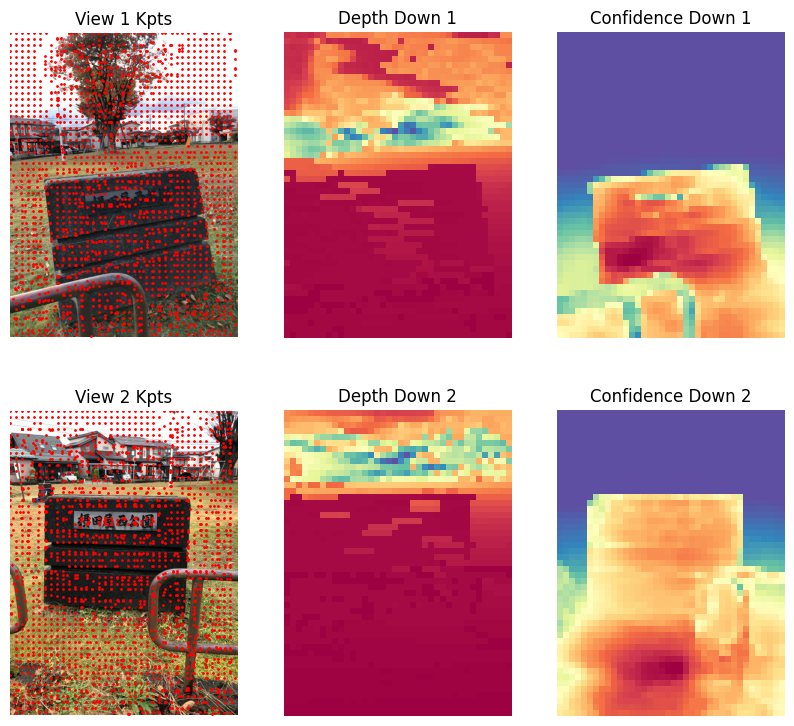

In [8]:
# visualize the downsampled maps 
fig, axs = plt.subplots(2, 3, figsize=(10, 9))

kps1_down_cpu = kps1_down.squeeze(0).cpu().numpy().reshape(2, -1).T
kps2_down_cpu = kps2_down.squeeze(0).cpu().numpy().reshape(2, -1).T

for i, (img, kps, depth, conf) in enumerate(zip(viz_imgs, [kps1_down_cpu, kps2_down_cpu], [depth1_down, depth2_down], [conf1_down, conf2_down])):
    axs[i, 0].imshow(img)
    axs[i, 0].scatter(kps[:, 0], kps[:, 1], c='r', s=1)
    axs[i, 0].set_title(f"View {i+1} Kpts")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(depth.squeeze(0).squeeze(0).cpu().numpy(), cmap='Spectral')
    axs[i, 1].set_title(f"Depth Down {i+1}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(conf.squeeze(0).squeeze(0).cpu().numpy(), cmap='Spectral_r')
    axs[i, 2].set_title(f"Confidence Down {i+1}")
    axs[i, 2].axis('off')